#Detecting Diabetic Retinopathy to Stop Blindness using Aravind Eye Hospital's Data
Millions of people suffer from [diabetic retinopathy](https://nei.nih.gov/health/diabetic/retinopathy), the leading cause of blindness among working aged adults. Aravind Eye Hospital in India hopes to detect and prevent this disease among people living in rural areas where medical screening is difficult to conduct. <br>
Currently, Aravind technicians travel to these rural areas to capture images and then rely on highly trained doctors to review the images and provide diagnosis. Their goal is to scale their efforts through technology; to gain the ability to automatically screen images for disease and provide information on how severe the condition may be. <br>
In this project, we will try to build a deep learning model to classify thousands of eye images from Aravind Eye Hospital based on the severity of the diabetic retinopathy. <br> <br>
This project is inspired by [APTOS 2019 Blindness Detection](https://www.kaggle.com/c/aptos2019-blindness-detection/overview) competition on Kaggle. <br> <br>
For reference, you can find the jupyter notebook in my [Github repo](https://github.com/anisdismail/diabetic-retinopathy-predictor), any feedback is appreciated!

---



## Setting up the Training Data
We will download the dataset from Kaggle, for further information about using Kaggle API, check the [Kaggle API's repository](https://github.com/Kaggle/kaggle-api)

After we athenticated our request, we can now download it:

In [0]:
!kaggle competitions download -c aptos2019-blindness-detection
!ls

100% 9.50G/9.52G [03:01<00:00, 57.9MB/s]
100% 9.52G/9.52G [03:01<00:00, 56.2MB/s]
aptos2019-blindness-detection.zip  kaggle.json	sample_data


In [0]:
!unzip aptos2019-blindness-detection.zip

Archive:  aptos2019-blindness-detection.zip
  inflating: train_images.zip        
  inflating: train.csv               
  inflating: test_images.zip         
  inflating: test.csv                
  inflating: sample_submission.csv   


In [0]:
!unzip train_images.zip

## Reading the Train Set
let's start by reading the train set:

In [0]:
import tensorflow as tf
tf.__version__

'1.14.0'

In [0]:
import pandas as pd
import numpy as np
SEED = 42
np.random.seed(SEED)
train=pd.read_csv("/content/train.csv")
train.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [0]:
len(train)

3662

Based on the data description provided [on Kaggle](https://www.kaggle.com/c/aptos2019-blindness-detection/data), we are provided with a large set of retina images taken using [fundus photography](https://en.wikipedia.org/wiki/Fundus_photography) under a variety of imaging conditions. <br>

A clinician has rated each image for the severity of diabetic retinopathy on a scale of 0 to 4:<br>

0 - No DR <br><br>

1 - Mild <br><br> 

2 - Moderate <br><br>

3 - Severe<br><br>

4 - Proliferative DR <br><br>

Like any real-world data set, we will encounter noise in both the images and labels. Images may contain artifacts, be out of focus, underexposed, or overexposed. The images were gathered from multiple clinics using a variety of cameras over an extended period of time, which will introduce further variation. In the upcoming steps we will try to preprocess the images to better highlight some important features.

Let's read the test data into a Pandas dataframe:

In [0]:
test=pd.read_csv("/content/test.csv")

Next, let's create a dictionnary that divides the images ids into 4 classes based on the diagnosis:

In [0]:
dict={0:"No DR",
    1:"Mild",
    2:"Moderate",
    3:"Severe",
    4:"Profilerative DR"}
dict

{0: 'No DR', 1: 'Mild', 2: 'Moderate', 3: 'Severe', 4: 'Profilerative DR'}

In [0]:
diags={}
for k in dict.keys():
  diags[k]=train[train["diagnosis"]==k]

Let's now check the distribution of each class in the train set:

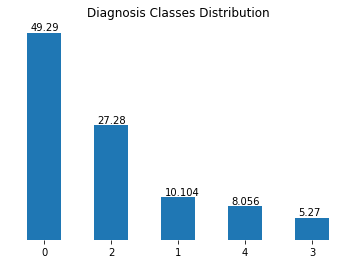

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

cases=train["diagnosis"].value_counts(normalize=True,ascending=False)*100
ax=cases.plot(kind="bar")
ax.set_xticklabels(cases.index,rotation=0)
ax.set_title("Diagnosis Classes Distribution")
for i, v in enumerate(cases.values):
    ax.text(i-0.2, v+0.5, str(round(v,3)))
for sp in ax.spines.keys():
  ax.spines[sp].set_visible(False)
ax.set_yticks([])
plt.show()

We notice that the classes are not uniformly distributed; we notice that around 50% of the train data is classified as part of class 0, and around 27.28% classified as part of class 1. These 2 classes only accouts for more that 75% of the training data, which will inrease the risks that the trained model to be largely affected by this bias in data. <br>
One solution is to calculate a weight for each class that will balance out the skew in the data and even out the distribution, which we will feed later on to the model as a seperate parameter.

In [0]:
weights=1./(train["diagnosis"].value_counts(normalize=True))
weights=weights/weights[0]
weights

0    1.000000
2    1.806807
1    4.878378
4    6.118644
3    9.352332
Name: diagnosis, dtype: float64

## Exploratory Data Analysis
Let's examine some random images of each class:

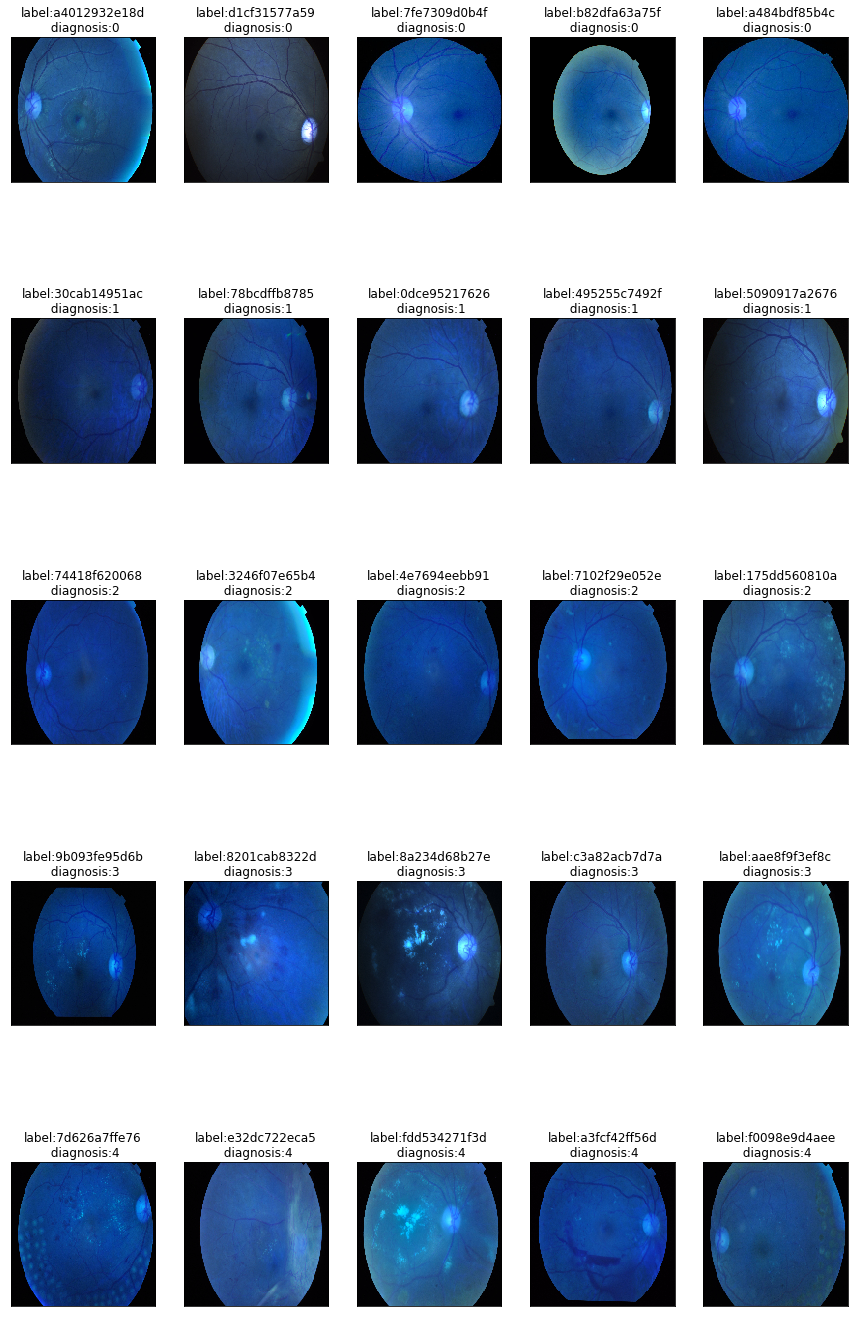

In [0]:
import cv2
from google.colab.patches import cv2_imshow

fig=plt.figure(figsize=(15,25))
for i,k in enumerate(diags.keys()):
  for j,v in enumerate(np.random.choice(diags[k]["id_code"],size=5)):
    ax=fig.add_subplot(5,5,5*(i) +(j+1),xticks=[], yticks=[])
    image=cv2.imread(v+".png",cv2.COLOR_BGR2RGB)
    image=cv2.resize(image,(150,150))
    plt.imshow(image)
    ax.set_title("label:"+v+"\n diagnosis:"+str(k))
plt.show()

## Preparing the Training Folders Architecture

First, let's start by creating the train, validation and test folders in the home directory:

In [0]:
!mkdir -p data/test
!mkdir -p data/validation
!mkdir -p data/train
!pwd

/content


In [0]:
#set directories variables
import os, shutil

home_dir = '/content'
base_dir = os.path.join(home_dir, 'data')
base_dir
train_dir=os.path.join(base_dir,"train")
print("train directory: "+train_dir)

test_dir=os.path.join(base_dir,"test")
print("test directory: "+test_dir)

validation_dir=os.path.join(base_dir,"validation")
print("validation directory: "+validation_dir)

train_0_dir = os.path.join(base_dir, 'train', '0')
train_1_dir = os.path.join(base_dir, 'train', '1')
train_2_dir = os.path.join(base_dir, 'train', '2')
train_3_dir = os.path.join(base_dir, 'train', '3')
train_4_dir = os.path.join(base_dir, 'train', '4')

test_0_dir = os.path.join(base_dir, 'test', '0')
test_1_dir = os.path.join(base_dir, 'test', '1')
test_2_dir = os.path.join(base_dir, 'test', '2')
test_3_dir = os.path.join(base_dir, 'test', '3')
test_4_dir = os.path.join(base_dir, 'test', '4')

validation_0_dir = os.path.join(base_dir, 'validation', '0')
validation_1_dir = os.path.join(base_dir, 'validation', '1')
validation_2_dir = os.path.join(base_dir, 'validation', '2')
validation_3_dir = os.path.join(base_dir, 'validation', '3')
validation_4_dir = os.path.join(base_dir, 'validation', '4')

train directory: /content/data/train
test directory: /content/data/test
validation directory: /content/data/validation


Next, we will append the extension ".png" to all files names

In [0]:
for df in diags.values():
  df["id_code_png"]=df["id_code"]+".png"

Next, we will group all entries belonging to the same classes into distinct folders to prepare data for ImageDataGenerator Class training:

In [0]:
from glob import glob
from tqdm import tqdm

for i in dict.keys():
  n_digits = int(np.log10(len(diags[i]))) + 1
  base_name = str(i)+"{}.png"
  for k, fname in tqdm(enumerate(diags[i]["id_code_png"])):
    new_name = base_name.format(str(k).zfill(n_digits))
    os.rename(fname, new_name)
    
    

1805it [00:00, 37443.03it/s]
370it [00:00, 35980.91it/s]
999it [00:00, 38550.66it/s]
193it [00:00, 34871.23it/s]
295it [00:00, 37944.12it/s]


We will split the training data into train set (85%) and validation set (15%):

In [0]:
import numpy as np
from glob import glob
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split

filenames=[]
zeros=glob('0???.png')+glob('0????.png')
for k in dict.keys():
  filenames = glob(str(k)+'???.png')+filenames
filenames=zeros+filenames

train_names , val_test_names = train_test_split(filenames, test_size=0.15)

for valname in val_test_names:
    os.rename(valname, 'data/validation/' + valname)

#for testname in test_names:
#    os.rename(testname, 'data/test/' + testname)

for trainname in train_names:
    os.rename(trainname, 'data/train/' + trainname)

Now, we move the pictures into their corresponding folders:

In [0]:
!mkdir -p data/train/0/ 
!mv data/train/0*.png data/train/0/ 

!mkdir -p data/train/1/ 
!mv data/train/1*.png data/train/1/ 

!mkdir -p data/train/2/ 
!mv data/train/2*.png data/train/2/ 

!mkdir -p data/train/3/ 
!mv data/train/3*.png data/train/3/ 

!mkdir -p data/train/4/ 
!mv data/train/4*.png data/train/4/ 

In [0]:
!mkdir -p data/validation/0/ 
!mv data/validation/0*.png data/validation/0/ 

!mkdir -p data/validation/1/ 
!mv data/validation/1*.png data/validation/1/ 

!mkdir -p data/validation/2/ 
!mv data/validation/2*.png data/validation/2/ 

!mkdir -p data/validation/3/ 
!mv data/validation/3*.png data/validation/3/ 

!mkdir -p data/validation/4/ 
!mv data/validation/4*.png data/validation/4/ 

## Preparing the Deep Learning Model

We will start by using a pretrained model whose layers are frozen except the top layer. We will chose the VGG16 model as starting point and eventually try other models to find the one  with the highest accuracy. <br>
Let's start by importing the model without its top layer:

In [0]:
from tensorflow.keras.applications import VGG16

conv_base=VGG16(weights="imagenet",include_top=False,input_shape=(150,150,3))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
58892288/58889256 [==============================] - 2s 0us/step


In [0]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

Next, let's add a custom output layer:

In [0]:
from tensorflow.keras import layers


model = tf.keras.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(5, activation='softmax',name="output"))

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
output (Dense)               (None, 5)                 1285      
Total params: 16,813,381
Trainable params: 16,813,381
Non-trainable params: 0
_________________________________________________________________


To not retrain the whole model again, we will freeze all the layers of the model except the custom output layers:

In [0]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [0]:
for layer in conv_base.layers:
  layer.trainable=False

In [0]:
conv_base.trainable = False

In [0]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


## Defining Callbacks
To prevent the model from overfitting the training data, we will define an EarlyStopper callback, whose role will be stop the model from training when its validation accuracy starts to decrease, which is usually the sign of overfitting. We will define as well a ReduceLROnPlateau callback, that will decrease the learning rate of the model when reaching a plateau in validation accuracy. 

In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

early_stopper = EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=5, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_acc', min_delta=0.0004, patience=2, factor=0.1, min_lr=1e-6, mode='auto', verbose=1)

## Training the Model

One way to reduce overfitting is to use ImageDataGenerator; in each epoch, the model will be exposed to the training data, but each image is augmented randomly based on the parameters set. This strategy will ensure that the model will be more robust face to new images. <br>
Once we defined the ImageDataGenerator object, we will train the model using the fit_generator method:

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers

train_datagen = ImageDataGenerator(
     horizontal_flip=True,
                                         vertical_flip=True, 
                                         rotation_range=40, 
                                         zoom_range=0.2, 
                                         shear_range=0.1,
                                        fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-4),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=50,class_weight=weights,callbacks=[early_stopper,reduce_lr])

Found 3112 images belonging to 5 classes.
Found 550 images belonging to 5 classes.
Epoch 1/50
100/100 [==============================] - 303s 3s/step - loss: 3.6959 - acc: 0.6130 - val_loss: 2.2884 - val_acc: 0.6970
Epoch 2/50
100/100 [==============================] - 289s 3s/step - loss: 1.3917 - acc: 0.6506 - val_loss: 1.0773 - val_acc: 0.7081
Epoch 3/50
100/100 [==============================] - 279s 3s/step - loss: 0.9130 - acc: 0.7179 - val_loss: 1.2546 - val_acc: 0.6606
Epoch 4/50
100/100 [==============================] - 284s 3s/step - loss: 0.8823 - acc: 0.7169 - val_loss: 0.9354 - val_acc: 0.7141
Epoch 5/50
100/100 [==============================] - 282s 3s/step - loss: 0.9061 - acc: 0.7145 - val_loss: 0.9254 - val_acc: 0.7242
Epoch 6/50
100/100 [==============================] - 285s 3s/step - loss: 0.8167 - acc: 0.7249 - val_loss: 0.8918 - val_acc: 0.7020
Epoch 7/50
100/100 [==============================] - 285s 3s/step - loss: 0.8051 - acc: 0.7430 - val_loss: 0.9058 - va

Next, we will save the model and its weights for easy retrieval later on:

In [0]:
model.save("model_1.h5")

## Plotting Accuracy and Error 

In [0]:
def plot_acc_loss(history,model_name):
  import matplotlib.pyplot as plt

  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.savefig(model_name+"acc.png")

  plt.figure()

  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.savefig(model_name+"loss.png")

  plt.show()


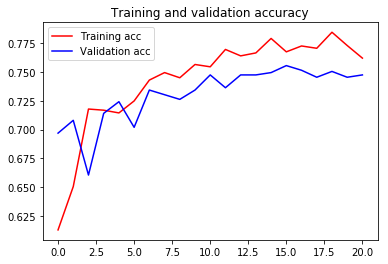

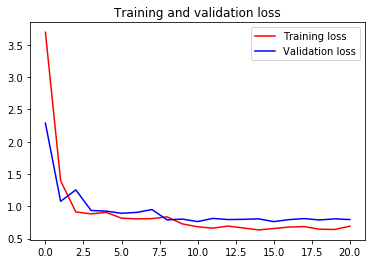

In [0]:
plot_acc_loss(history,"model_1")

As we notice from the previous plots, the maximum accuracy obtained on the validation set was around 74%, but we can do better. Next, we will try to fine-tune the model to try to increase its accuracy. 

## Improving the Model Accuracy by Adding Dropout and Batch Normalizaton

One approach to improve the accuracy and reduce overfitting is by adding a Dropout layer and a Batch Normalization layer to the dense layers: 

In [0]:
from tensorflow.keras import layers

model = tf.keras.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())
model.add(layers.Dense(5, activation='softmax'))


In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 1285      
Total params: 16,814,405
Trainable params: 2,099,205
Non-trainable params: 14,715,200
__________________________________

Next, we will freeze all the layers except the top layer:

In [0]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 32


In [0]:
conv_base.trainable = False

In [0]:
for layer in conv_base.layers:
  layer.trainable=False

In [0]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 6


Now we will train the model:

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers

train_datagen = ImageDataGenerator(
     horizontal_flip=True,
                                         vertical_flip=True, 
                                         rotation_range=40, 
                                         zoom_range=0.2, 
                                         shear_range=0.1,
                                        fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-4),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=50,class_weight=weights,callbacks=[early_stopper,reduce_lr])

Found 3112 images belonging to 5 classes.
Found 550 images belonging to 5 classes.
Epoch 1/50
100/100 [==============================] - 345s 3s/step - loss: 1.1732 - acc: 0.5935 - val_loss: 1.1062 - val_acc: 0.6788
Epoch 2/50
100/100 [==============================] - 318s 3s/step - loss: 0.9400 - acc: 0.6707 - val_loss: 0.8476 - val_acc: 0.7253
Epoch 3/50
100/100 [==============================] - 318s 3s/step - loss: 0.8454 - acc: 0.7088 - val_loss: 0.7494 - val_acc: 0.7242
Epoch 4/50
100/100 [==============================] - 317s 3s/step - loss: 0.7938 - acc: 0.7200 - val_loss: 0.7140 - val_acc: 0.7495
Epoch 5/50
100/100 [==============================] - 315s 3s/step - loss: 0.7511 - acc: 0.7289 - val_loss: 0.8381 - val_acc: 0.7455
Epoch 6/50
 99/100 [============================>.] - ETA: 2s - loss: 0.7900 - acc: 0.7099
Epoch 00006: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
100/100 [==============================] - 321s 3s/step - loss: 0.7927 - acc: 0.

In [0]:
model.save("model_2.h5")

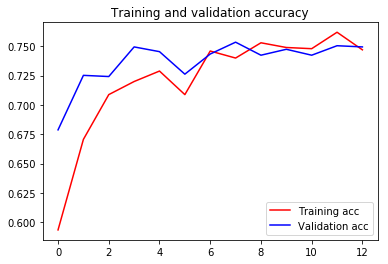

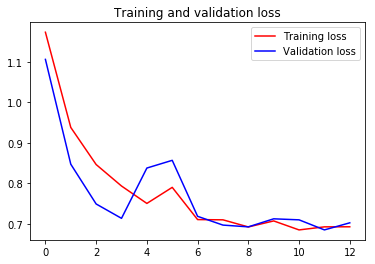

In [0]:
plot_acc_loss(history,"model_2")

As we notice from the previous plots, the maximum accuracy obtained on the validation set increased to reach around 75.56%, but we can do better. Next, we will try another approach to further improve the model.

In [0]:
NB_VALID_STEPS = validation_generator.n // validation_generator.batch_size
NB_VALID_STEPS

27

## Unfreezing the Last Layers

Another approach is to unfreeze the last layers and retrain the model again.
Let's repeat the process and unfreeze the last layer:

In [0]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

We will unfreeze the block5_conv1 layer:

In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50,callbacks=[early_stopper,reduce_lr],class_weight=weights)

Epoch 1/100
100/100 [==============================] - 348s 3s/step - loss: 0.6614 - acc: 0.7651 - val_loss: 0.6943 - val_acc: 0.7596
Epoch 2/100
100/100 [==============================] - 316s 3s/step - loss: 0.6952 - acc: 0.7555 - val_loss: 0.7470 - val_acc: 0.7424
Epoch 3/100
 99/100 [============================>.] - ETA: 2s - loss: 0.6674 - acc: 0.7641
Epoch 00003: ReduceLROnPlateau reducing learning rate to 1e-06.
100/100 [==============================] - 323s 3s/step - loss: 0.6654 - acc: 0.7645 - val_loss: 0.7011 - val_acc: 0.7465
Epoch 4/100
100/100 [==============================] - 324s 3s/step - loss: 0.6480 - acc: 0.7755 - val_loss: 0.6667 - val_acc: 0.7566
Epoch 5/100
100/100 [==============================] - 317s 3s/step - loss: 0.6499 - acc: 0.7671 - val_loss: 0.6714 - val_acc: 0.7626
Epoch 6/100
100/100 [==============================] - 316s 3s/step - loss: 0.6675 - acc: 0.7540 - val_loss: 0.6768 - val_acc: 0.7475
Epoch 7/100
100/100 [==============================]

In [0]:
model.save("model_3.h5")

Let's visualize the variation of the accuracy and loss in the training and validation set:

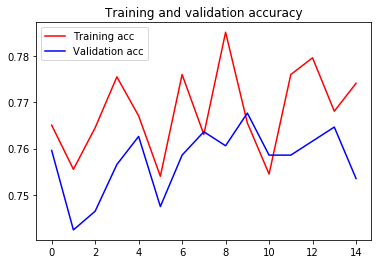

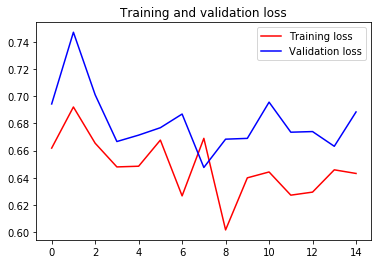

In [0]:
plot_acc_loss(history,"model_3")

Let's evaluate the accuracy of the model:

In [0]:
(eval_loss, eval_accuracy) = tqdm(
    model.evaluate_generator(generator=validation_generator, steps=NB_VALID_STEPS))
print("\nAccuracy: {:.2f}%".format(eval_accuracy * 100))
print("Loss: {}".format(eval_loss))

100%|██████████| 2/2 [00:00<00:00, 7313.52it/s]


Accuracy: 75.74%
Loss: 0.6690652127619143


## Evaluating the Model Accuracy

Let's find the confusion matrix, which will help us pinpoint the weaknesses in our model:

In [0]:
train["id_code_png"]=train["id_code"]+".png"
train.head()

,id_code,diagnosis,id_code_png
0,000c1434d8d7,2,000c1434d8d7.png
1,001639a390f0,4,001639a390f0.png
2,0024cdab0c1e,1,0024cdab0c1e.png
3,002c21358ce6,0,002c21358ce6.png
4,005b95c28852,0,005b95c28852.png


Let's get the predicted values for the validation set's images:

In [0]:
pred_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=1,
        class_mode='categorical',
shuffle=False)
valid_preds=model.predict_generator(generator=pred_generator,steps=len(val_test_names))
valid_preds

Found 550 images belonging to 5 classes.


array([[9.99624491e-01, 8.33924860e-05, 1.65061792e-05, 2.16799104e-04,
        5.87192299e-05],
       [9.98235822e-01, 1.15881662e-03, 2.53151429e-05, 3.41749022e-04,
        2.38192239e-04],
       [9.99714553e-01, 1.68057973e-04, 2.44450293e-05, 7.76041634e-05,
        1.53919882e-05],
       ...,
       [3.15630585e-01, 5.20390153e-01, 9.49328765e-02, 6.48841495e-03,
        6.25579432e-02],
       [1.07243552e-03, 1.57002304e-02, 7.49730289e-01, 6.64745122e-02,
        1.67022467e-01],
       [1.38024941e-01, 3.77257943e-01, 3.25838447e-01, 4.39971425e-02,
        1.14881545e-01]], dtype=float32)

Now, we will get the predicted classes with the highest probabilities for each instance into a seperate array: 

In [0]:
preds=np.argmax(valid_preds,axis=1)

Next, let's sort the predicted labels:

In [0]:
sorted_val_test_names=sorted(val_test_names)
labels=np.zeros(len(val_test_names))
for i in range(len(val_test_names)):
  labels[i]=int(sorted_val_test_names[i][0])
labels

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [0]:
vals,counts=np.unique(labels,return_counts=True)
print("Unique Values : " ,vals)
print("Occurrence Count : ", counts)

Unique Values :  [0. 1. 2. 3. 4.]
Occurrence Count :  [293  57 128  30  42]


Now, we are ready to find the confusion matrix:

In [0]:
from sklearn.metrics import confusion_matrix
conf_mat=confusion_matrix(labels,preds)
conf_mat

array([[289,   4,   0,   0,   0],
       [ 14,  19,  23,   0,   1],
       [ 13,  18,  94,   2,   1],
       [  1,   1,  19,   3,   6],
       [  1,   5,  24,   2,  10]])

Using the obtained matrix, let's compute the percentage of error for each class:

In [0]:
perc_mat=(conf_mat/counts[:,None])
perc_mat

array([[0.98634812, 0.01365188, 0.        , 0.        , 0.        ],
       [0.24561404, 0.33333333, 0.40350877, 0.        , 0.01754386],
       [0.1015625 , 0.140625  , 0.734375  , 0.015625  , 0.0078125 ],
       [0.03333333, 0.03333333, 0.63333333, 0.1       , 0.2       ],
       [0.02380952, 0.11904762, 0.57142857, 0.04761905, 0.23809524]])

Let's plot the percentages matrix:

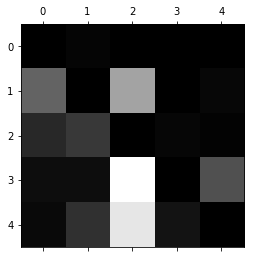

In [0]:
np.fill_diagonal(perc_mat, 0)
plt.matshow(perc_mat, cmap=plt.cm.gray)
plt.savefig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

Let's calculate the f1 score for this model:

In [0]:
from sklearn.metrics import f1_score
f1=f1_score(labels,preds,average="weighted")
f1

0.7280408477216987

## Trying ResNet model
To try to improve the accuracy of the model, let's try another model - Resnet50. 
Using this model, let's repeat the process we used in the previous model: 

In [0]:
from tensorflow.keras.applications import ResNet50

res_base=ResNet50(include_top = False, pooling = "avg", weights = "imagenet",input_shape=(224,224,3))

94658560/94653016 [==============================] - 1s 0us/step


In [0]:
res_model = tf.keras.Sequential()
res_model.add(res_base)
res_model.add(layers.Dropout(0.3))
res_model.add(layers.Dense(1024, activation='relu'))
res_model.add(layers.Dropout(0.2))
res_model.add(layers.Dense(512, activation='relu'))
res_model.add(layers.Dropout(0.2))
res_model.add(layers.BatchNormalization())
res_model.add(layers.Dense(5, activation='softmax'))


In [0]:
res_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)              

In [0]:
print('This is the number of trainable weights '
      'before freezing the res base:', len(res_model.trainable_weights))

This is the number of trainable weights before freezing the res base: 220


In [0]:
for layer in res_base.layers:
  layer.trainable=False

In [0]:
res_base.trainable = False

In [0]:
print('This is the number of trainable weights '
      'after freezing the res base:', len(res_model.trainable_weights))

This is the number of trainable weights after freezing the res base: 8


In [0]:
train_datagen = ImageDataGenerator(
     horizontal_flip=True,
     vertical_flip=True, 
     rotation_range=360, 
     zoom_range=0.2, 
     shear_range=0.1,
    fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(224, 224),
        batch_size=12,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=12,
        class_mode='categorical')

res_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-3),
              metrics=['acc'])

res_history = res_model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=50,class_weight=weights,callbacks=[early_stopper,reduce_lr])

Found 3112 images belonging to 5 classes.
Found 550 images belonging to 5 classes.
Epoch 1/50
100/100 [==============================] - 215s 2s/step - loss: 1.8846 - acc: 0.3042 - val_loss: 1.3323 - val_acc: 0.5552
Epoch 2/50
100/100 [==============================] - 201s 2s/step - loss: 1.4375 - acc: 0.4513 - val_loss: 1.2773 - val_acc: 0.5619
Epoch 3/50
100/100 [==============================] - 196s 2s/step - loss: 1.3303 - acc: 0.5201 - val_loss: 1.3701 - val_acc: 0.5736
Epoch 4/50
100/100 [==============================] - 200s 2s/step - loss: 1.2381 - acc: 0.5608 - val_loss: 1.3467 - val_acc: 0.5769
Epoch 5/50
100/100 [==============================] - 199s 2s/step - loss: 1.1349 - acc: 0.5858 - val_loss: 1.4190 - val_acc: 0.5853
Epoch 6/50
100/100 [==============================] - 195s 2s/step - loss: 1.0635 - acc: 0.6342 - val_loss: 1.4546 - val_acc: 0.5836
Epoch 7/50
 99/100 [============================>.] - ETA: 1s - loss: 1.1181 - acc: 0.6051
Epoch 00007: ReduceLROnPlate

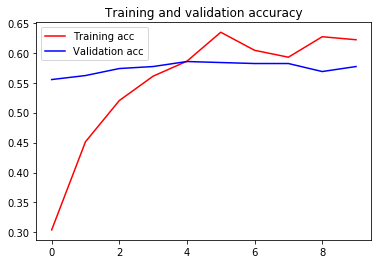

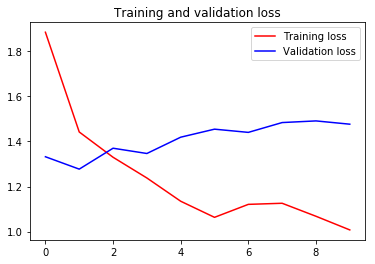

In [0]:
plot_acc_loss(res_history,"res_model")

We notice that the accuracy of the model did not improve at all using this model, instead it decreased. It seems that ResNet50 is not very fit for this kind of pictures. 

## Another Approach: Model Training Based on Extracted Features
The last approach we will be tackling is using a pretrained model with the latest layer removed, to extract the features of the pictures, which we will later on feed into a machine learning model that will try to predict the severity of the disease. <br>
We will be using MobileNetV2 model, one of the models with the highest accuracy:

In [0]:
from tensorflow.keras.applications import MobileNetV2
inc_base=MobileNetV2(include_top=False, weights='imagenet', input_shape=(224,224,3))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
9412608/9406464 [==============================] - 1s 0us/step


Let's extract the features from the training and validation sets:

In [0]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7,7,1280))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = inc_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = np.argmax(labels_batch,axis=1)
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_samples = 3112
validation_samples = 550

train_features, train_labels = extract_features(train_dir, train_samples)
validation_features, validation_labels = extract_features(validation_dir, validation_samples)

Found 3112 images belonging to 5 classes.
Found 550 images belonging to 5 classes.


In [0]:
train_features = np.reshape(train_features, (train_samples, 7 * 7 * 1280))
validation_features = np.reshape(validation_features, (validation_samples, 7 * 7 * 1280))

In [0]:
from tensorflow.keras.utils import to_categorical
train_labels_cat = to_categorical(train_labels)
validation_labels_cat=to_categorical(validation_labels)

### Training a Neural Network Using Extracted Features
Now we have the extracted features from the train and validation sets ready, we will first train a neural netwrork on the training set features:

In [0]:
inc_model = tf.keras.Sequential()
inc_model.add(layers.Dense(256, activation='relu', input_dim=7 * 7 * 1280))
inc_model.add(layers.Dropout(0.5))
inc_model.add(layers.BatchNormalization())
inc_model.add(layers.Dense(5, activation='softmax'))

inc_model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='categorical_crossentropy',
              metrics=['acc'])

history = inc_model.fit(train_features, train_labels_cat,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels_cat))

Train on 3112 samples, validate on 550 samples
Epoch 1/30
3112/3112 [==============================] - 5s 1ms/sample - loss: 1.0481 - acc: 0.6263 - val_loss: 0.7230 - val_acc: 0.7836
Epoch 2/30
3112/3112 [==============================] - 4s 1ms/sample - loss: 0.7359 - acc: 0.7349 - val_loss: 0.6102 - val_acc: 0.7909
Epoch 3/30
3112/3112 [==============================] - 4s 1ms/sample - loss: 0.6033 - acc: 0.7860 - val_loss: 0.5955 - val_acc: 0.7982
Epoch 4/30
3112/3112 [==============================] - 4s 1ms/sample - loss: 0.5297 - acc: 0.8207 - val_loss: 0.5487 - val_acc: 0.7909
Epoch 5/30
3112/3112 [==============================] - 4s 1ms/sample - loss: 0.4678 - acc: 0.8470 - val_loss: 0.5651 - val_acc: 0.8000
Epoch 6/30
3112/3112 [==============================] - 4s 1ms/sample - loss: 0.3919 - acc: 0.8699 - val_loss: 0.5583 - val_acc: 0.8000
Epoch 7/30
3112/3112 [==============================] - 4s 1ms/sample - loss: 0.3566 - acc: 0.8846 - val_loss: 0.5591 - val_acc: 0.7964
E

Let's plot the accuracy and error for the training and validation sets:

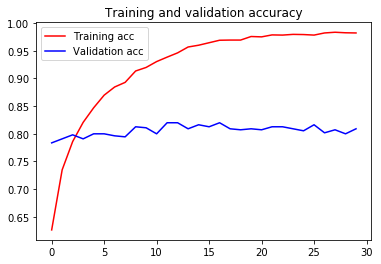

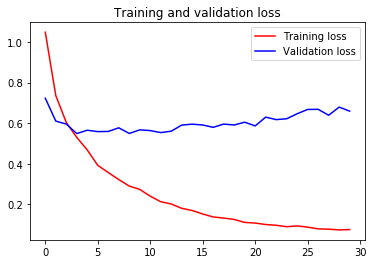

In [0]:
plot_acc_loss(history,"inc_model")

In [0]:
(eval_loss, eval_accuracy) = tqdm(
    inc_model.evaluate(validation_features, validation_labels_cat))
print("\nAccuracy: {:.2f}%".format(eval_accuracy * 100))
print("Loss: {}".format(eval_loss))

550/550 [==============================] - 0s 396us/sample - loss: 0.6592 - acc: 0.8091


100%|██████████| 2/2 [00:00<00:00, 623.83it/s]


Accuracy: 80.91%
Loss: 0.659194563518871


Now we notice that the accuracy of the model has increased to around 81%!!

Finally, let's generate a classification report to evlauate the performance of the model:

In [0]:
print(classification_report(validation_labels, pred_valid_labels))

              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96       293
         1.0       0.66      0.40      0.50        57
         2.0       0.60      0.88      0.71       128
         3.0       0.40      0.07      0.11        30
         4.0       0.55      0.14      0.23        42

    accuracy                           0.79       550
   macro avg       0.63      0.49      0.50       550
weighted avg       0.77      0.79      0.75       550



We will stop at this stage, but there is a lot of room for improvement. Further steps to improve the model might be:
- trying other algorithms and tuning their hyperparameters
- preprocessing the images to better expose the most important features 
- trying other pretrained models

<bR>
 
You reached the end of the project! Thank you for following till the end, and stay tuned for more projects!